In [ ]:
import tensorflow as tf
keras = tf.keras
import warnings
warnings.filterwarnings("ignore")
import gensim, re
import numpy as np
import pandas as pd
import openpyxl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Bidirectional, Dropout, Conv1D
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install bltk
!pip install pandas
import pandas as pd
from bltk.langtools import remove_stopwords
import regex as re
from bltk.langtools import Tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df=pd.read_excel('/content/drive/MyDrive/suicide/suicide_data2.xlsx')
#main_data = pd.read_excel( "/content/drive/MyDrive/suicide/suicide_data2.xlsx" )
df=pd.read_excel('/content/drive/MyDrive/suicide/suicide_data2.xlsx')
main_data = pd.read_excel( "/content/drive/MyDrive/suicide/suicide_data2.xlsx" )
labels = main_data['label'].tolist()
df.head()

,text,label
0,আমি একদিন নিজেকে মেরে ফেলব এই বিষয়টি আমি নিশ...,1
1,বেচে থাকার কোন কারণ আমি ভাবতে পারি না। জীবনের ...,1
2,আমি কমপক্ষে ১ বছর ধরে সুইসাইড করার কথা ভাবছি। ...,1
3,আমার আর বাঁচার দরকার নেই। আমি ওর সাথে সম্পর্ক...,1
4,আমি এভাবে আর বাঁচব না। আমার হতাশা ও আত্মহত্যার...,1


In [ ]:
from bltk.langtools.banglachars import (vowels,
                                        vowel_signs,
                                        consonants,
                                        digits,
                                        operators,
                                        punctuations,
                                        others)
print(f'Vowels: {vowels}')
print(f'Vowel signs: {vowel_signs}')
print(f'Consonants: {consonants}')
print(f'Digits: {digits}')
print(f'Operators: {operators}')
print(f'Punctuation marks: {punctuations}')
print(f'Others: {others}')

Vowels: ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'ঌ', 'এ', 'ঐ', 'ও', 'ঔ']
Vowel signs: ['া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ']
Consonants: ['ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ']
Digits: ['০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']
Operators: ['=', '+', '-', '*', '/', '%', '<', '>', '×', '÷']
Punctuation marks: ['।', ',', ';', ':', '?', '!', "'", '.', '"', '-', '[', ']', '{', '}', '(', ')', '–', '—', '―', '~']
Others: ['৳', '৺', '্', 'ঀ', 'ঽ', '#', '$']


In [ ]:
df.shape[0]

1402

In [ ]:
def punc(tokens):
  valid_tokens=[]
  for token in tokens:
    if token not in punctuations:
      valid_tokens.append(token)
  tokens=valid_tokens
  return tokens

In [ ]:
new_list=[]
for c in vowels:
  new_list.append(c)
for c in vowel_signs:
  new_list.append(c)
for c in consonants:
  new_list.append(c)
new_list.append('্')
new_list.append('য়')
def tokenize(text):
    token=[]
    text=str(text)
    #print(text)
    new_text=""
    for c in text:
      if c in new_list:
        new_text=new_text+c
      else:
        new_text=new_text+' '
    tokenizer = Tokenizer()
    text=new_text
    words=tokenizer.word_tokenizer(text)
    for word in words:
      if word not in token:
        siz=0
        for c in word:
          siz=siz+1
        if siz>0:
          token.append(word)
    return token

In [ ]:
def stp_remove(tkn):
  words=remove_stopwords(tkn, level='soft')
  return words

In [ ]:
df2=pd.read_excel('/content/drive/MyDrive/suicide/rules.xlsx')
pd.set_option('display.max_rows', None)
df2.head()
#print(df2)

,rule
0,ই
1,ও
2,তো
3,কে
4,তে


In [ ]:
def stemming(text, pattern):
    mi=min(len(text),len(pattern))
    cnt=0
    len_text=len(text)
    len_pattern=len(pattern)
    cnt=-2
    for i in range(mi):
      if(text[len_text-(i+1)]!=pattern[len_pattern-(i+1)]):
        break
      cnt=i
    len_text=len_text-cnt
    txt=text
    if cnt+1==mi:
      txt = text[0:len_text-1]
    return txt

In [ ]:
posts= list()
for text in df["text"]:
    text=str(text)
    text=tokenize(text)
    text=punc(text)
    text=stp_remove(text)
    new_tokens=[]
    for txt in text:
       temp=txt
       for rule in df2["rule"]:
           temp=stemming(txt,rule)
           if temp!=txt:
               break
       if len(temp)>0:
          new_tokens.append(temp)
    posts.append(text)
cleaned_data=posts

In [ ]:
print(cleaned_data)

[['একদিন', 'মের', 'ফেলব', 'বিষয', 'নিশ্চিত', 'জীবন', 'অস্তিত্বহীন', 'বন্ধু', 'রয', 'পরিব', 'বিচ্ছিন্ন', 'হয', 'ে', 'সবসম', 'বিষাক্ত', 'চিন্তায', 'ডুব', 'আ'], ['বেচ', 'ভাব', 'পারি', 'জীবন', 'কোন', 'ক্ষেত্রে', 'স্থিতিশীলতা', 'আতঙ্কিত', 'হয', 'পড', 'তাছাড়া', 'বাবা', 'মা', 'চা', 'জীবন', 'খারাপ', 'পার', 'অনুভব', 'করে', 'মর', 'প্রস্তুত'], ['কমপক্ষ', 'বছর', 'ধর', 'সুইসাইড', 'কর', 'কথা', 'ভাব', 'আজ', 'তম', 'জন্মদিন', 'বিষয', 'ইদানীং', 'অত্যন্ত', 'খারাপ', 'যা', 'চাকরি', 'হারিয', 'ে', 'এমন', 'দেশ', 'বাস', 'করি', 'যেখান', 'বেকারত্ব', 'হ', 'বেশি', 'কাজ', 'ক্ষেত্র', 'অনেক', 'সুযোগ', 'এমনকি', 'এ', 'বাইরে', 'কাজ', 'খুঁজ', 'পাওয', 'শক্ত', 'হতাশ', 'বোধ', 'আত্মঘাতী', 'চিন্তাভাবনাগুলি', 'তুল'], ['আর', 'বাঁচ', 'দরক', 'ওর', 'সাথ', 'সম্পর্ক', 'ছিন্ন', 'করে', 'পরিবার', 'সদস্য', 'দূর', 'ঠেল', 'দিয', 'ে', 'কোথা', 'জায়গা'], ['এভাব', 'আর', 'বাঁচব', 'হতাশা', 'আত্মহত্য', 'চেষ্ট', 'অনেক', 'ইতিহাস', 'রয', 'এ', 'অবাক', 'হওয'], ['জানি', 'আজ', 'রাত', 'চল', 'যাব', 'কিনা', 'আশা', 'করি', 'পা', 'অনুভূতিগু', 'অজ্ঞান', 'হয',

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
features = 100
tokenizer = Tokenizer(num_words=features)

In [ ]:

tokenizer.fit_on_texts(cleaned_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(cleaned_data)

maxlen=10
padType='post'

X = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
y = np.asarray(pd.get_dummies(labels))

In [ ]:
len(X), len(y)

(1402, 1402)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

In [ ]:
def get_gru_model(num_of_layer):
    gru_model = Sequential()
    gru_model.add(Embedding(4000, features, input_length = X.shape[1]))
    
    for i in range(num_of_layer):
        if i>0:
            gru_model.add(GRU(features, return_sequences=True))
            
    gru_model.add(GRU(features, return_sequences=False))
    gru_model.add(Dense(10, activation="relu"))
    gru_model.add(Dense(y.shape[1], activation="softmax"))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    gru_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    # model.summary()
    return gru_model;

In [ ]:


def get_lstm_model(num_of_layer):
    lstm_model = Sequential()
    lstm_model.add(Embedding(4000, features, input_length = X.shape[1]))
    
    for i in range(num_of_layer):
        if i>0:
            lstm_model.add(LSTM(features, return_sequences=True))
        
    lstm_model.add(LSTM(features, return_sequences=False))
    lstm_model.add(Dense(10, activation="relu"))
    lstm_model.add(Dense(y.shape[1], activation="softmax"))

    opt = keras.optimizers.Adam(learning_rate=0.0001)
    lstm_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return lstm_model;

In [ ]:
def run_model(model, batch, epochs):
    history = model.fit(X_train, y_train, batch, epochs, validation_data=(X_test, y_test), verbose=1)
    return history

In [ ]:
#plot

import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

Epoch 1/10
36/36 [==============================] - 6s 48ms/step - loss: 0.6912 - accuracy: 0.5263 - val_loss: 0.6565 - val_accuracy: 0.7260
Epoch 2/10
36/36 [==============================] - 1s 34ms/step - loss: 0.5651 - accuracy: 0.8528 - val_loss: 0.4895 - val_accuracy: 0.8505
Epoch 3/10
36/36 [==============================] - 1s 39ms/step - loss: 0.4461 - accuracy: 0.8912 - val_loss: 0.4512 - val_accuracy: 0.8683
Epoch 4/10
36/36 [==============================] - 1s 31ms/step - loss: 0.4114 - accuracy: 0.9001 - val_loss: 0.4299 - val_accuracy: 0.8648
Epoch 5/10
36/36 [==============================] - 1s 24ms/step - loss: 0.3791 - accuracy: 0.9099 - val_loss: 0.4157 - val_accuracy: 0.8719
Epoch 6/10
36/36 [==============================] - 1s 24ms/step - loss: 0.3651 - accuracy: 0.9028 - val_loss: 0.3955 - val_accuracy: 0.8790
Epoch 7/10
36/36 [==============================] - 1s 24ms/step - loss: 0.3618 - accuracy: 0.8858 - val_loss: 0.3919 - val_accuracy: 0.8683
Epoch 8/10
36

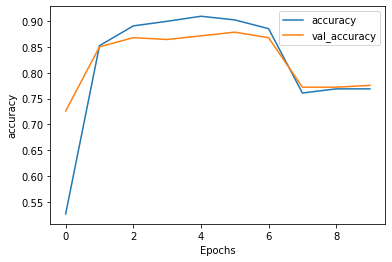

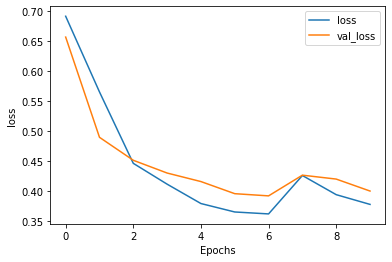

Epoch 1/10
36/36 [==============================] - 18s 121ms/step - loss: 0.6376 - accuracy: 0.6664 - val_loss: 0.5140 - val_accuracy: 0.8470
Epoch 2/10
36/36 [==============================] - 2s 65ms/step - loss: 0.4285 - accuracy: 0.8867 - val_loss: 0.4220 - val_accuracy: 0.8577
Epoch 3/10
36/36 [==============================] - 2s 66ms/step - loss: 0.3700 - accuracy: 0.8983 - val_loss: 0.4192 - val_accuracy: 0.8399
Epoch 4/10
36/36 [==============================] - 3s 95ms/step - loss: 0.3641 - accuracy: 0.8903 - val_loss: 0.3967 - val_accuracy: 0.8683
Epoch 5/10
36/36 [==============================] - 2s 61ms/step - loss: 0.3366 - accuracy: 0.9063 - val_loss: 0.3771 - val_accuracy: 0.8754
Epoch 6/10
36/36 [==============================] - 2s 63ms/step - loss: 0.3179 - accuracy: 0.9054 - val_loss: 0.3706 - val_accuracy: 0.8719
Epoch 7/10
36/36 [==============================] - 2s 61ms/step - loss: 0.3040 - accuracy: 0.9135 - val_loss: 0.3610 - val_accuracy: 0.8754
Epoch 8/10


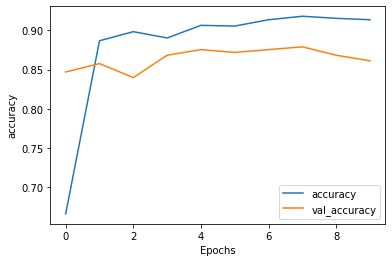

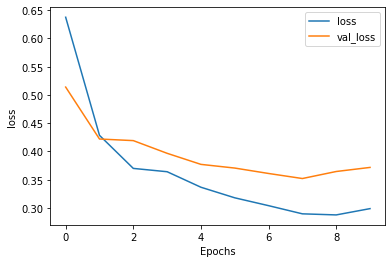

Epoch 1/10
36/36 [==============================] - 26s 174ms/step - loss: 0.5452 - accuracy: 0.7074 - val_loss: 0.3774 - val_accuracy: 0.8541
Epoch 2/10
36/36 [==============================] - 3s 91ms/step - loss: 0.3153 - accuracy: 0.8858 - val_loss: 0.3669 - val_accuracy: 0.8648
Epoch 3/10
36/36 [==============================] - 4s 101ms/step - loss: 0.2843 - accuracy: 0.9081 - val_loss: 0.3449 - val_accuracy: 0.8683
Epoch 4/10
36/36 [==============================] - 3s 83ms/step - loss: 0.2677 - accuracy: 0.9117 - val_loss: 0.3447 - val_accuracy: 0.8577
Epoch 5/10
36/36 [==============================] - 3s 76ms/step - loss: 0.2646 - accuracy: 0.9019 - val_loss: 0.3706 - val_accuracy: 0.8612
Epoch 6/10
36/36 [==============================] - 3s 95ms/step - loss: 0.2603 - accuracy: 0.9108 - val_loss: 0.3389 - val_accuracy: 0.8719
Epoch 7/10
36/36 [==============================] - 4s 97ms/step - loss: 0.2599 - accuracy: 0.9090 - val_loss: 0.3348 - val_accuracy: 0.8719
Epoch 8/10

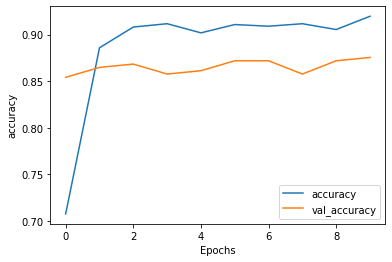

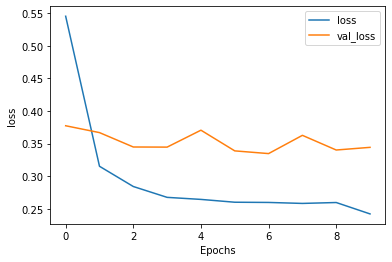

Epoch 1/20
36/36 [==============================] - 6s 46ms/step - loss: 0.6803 - accuracy: 0.5789 - val_loss: 0.6299 - val_accuracy: 0.7972
Epoch 2/20
36/36 [==============================] - 1s 37ms/step - loss: 0.4694 - accuracy: 0.8252 - val_loss: 0.3696 - val_accuracy: 0.8754
Epoch 3/20
36/36 [==============================] - 2s 43ms/step - loss: 0.3335 - accuracy: 0.8974 - val_loss: 0.3735 - val_accuracy: 0.8719
Epoch 4/20
36/36 [==============================] - 1s 27ms/step - loss: 0.3057 - accuracy: 0.9135 - val_loss: 0.3634 - val_accuracy: 0.8719
Epoch 5/20
36/36 [==============================] - 1s 22ms/step - loss: 0.2893 - accuracy: 0.9188 - val_loss: 0.3699 - val_accuracy: 0.8577
Epoch 6/20
36/36 [==============================] - 1s 23ms/step - loss: 0.2836 - accuracy: 0.9179 - val_loss: 0.3690 - val_accuracy: 0.8648
Epoch 7/20
36/36 [==============================] - 1s 22ms/step - loss: 0.2742 - accuracy: 0.9197 - val_loss: 0.3653 - val_accuracy: 0.8612
Epoch 8/20
36

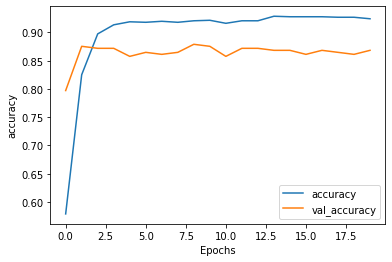

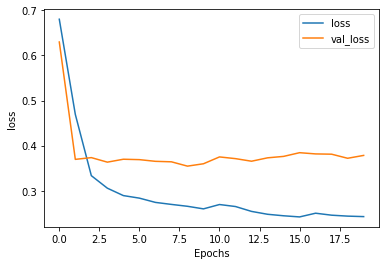

Epoch 1/20
36/36 [==============================] - 18s 127ms/step - loss: 0.6428 - accuracy: 0.6494 - val_loss: 0.4754 - val_accuracy: 0.8149
Epoch 2/20
36/36 [==============================] - 3s 73ms/step - loss: 0.4257 - accuracy: 0.8707 - val_loss: 0.4330 - val_accuracy: 0.8577
Epoch 3/20
36/36 [==============================] - 3s 81ms/step - loss: 0.4050 - accuracy: 0.8698 - val_loss: 0.4147 - val_accuracy: 0.8612
Epoch 4/20
36/36 [==============================] - 2s 61ms/step - loss: 0.3657 - accuracy: 0.8992 - val_loss: 0.4010 - val_accuracy: 0.8577
Epoch 5/20
36/36 [==============================] - 2s 64ms/step - loss: 0.3487 - accuracy: 0.9054 - val_loss: 0.3949 - val_accuracy: 0.8577
Epoch 6/20
36/36 [==============================] - 2s 59ms/step - loss: 0.3401 - accuracy: 0.9019 - val_loss: 0.3846 - val_accuracy: 0.8683
Epoch 7/20
36/36 [==============================] - 2s 61ms/step - loss: 0.3182 - accuracy: 0.9072 - val_loss: 0.3762 - val_accuracy: 0.8612
Epoch 8/20


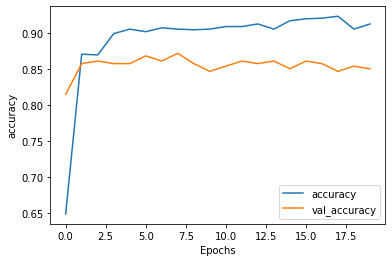

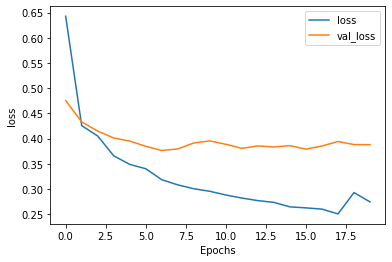

Epoch 1/20
36/36 [==============================] - 25s 204ms/step - loss: 0.7356 - accuracy: 0.5013 - val_loss: 0.7038 - val_accuracy: 0.4947
Epoch 2/20
36/36 [==============================] - 3s 94ms/step - loss: 0.6941 - accuracy: 0.5013 - val_loss: 0.6342 - val_accuracy: 0.4947
Epoch 3/20
36/36 [==============================] - 3s 93ms/step - loss: 0.6146 - accuracy: 0.5013 - val_loss: 0.5969 - val_accuracy: 0.4947
Epoch 4/20
36/36 [==============================] - 4s 124ms/step - loss: 0.5718 - accuracy: 0.8359 - val_loss: 0.5767 - val_accuracy: 0.8221
Epoch 5/20
36/36 [==============================] - 3s 90ms/step - loss: 0.5495 - accuracy: 0.8537 - val_loss: 0.5467 - val_accuracy: 0.8327
Epoch 6/20
36/36 [==============================] - 3s 92ms/step - loss: 0.4940 - accuracy: 0.8305 - val_loss: 0.5009 - val_accuracy: 0.7829
Epoch 7/20
36/36 [==============================] - 4s 99ms/step - loss: 0.4652 - accuracy: 0.8341 - val_loss: 0.6318 - val_accuracy: 0.6085
Epoch 8/20

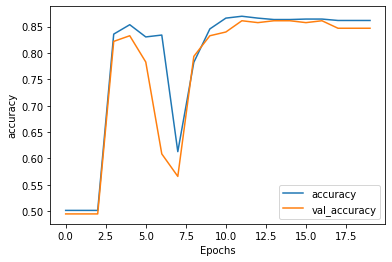

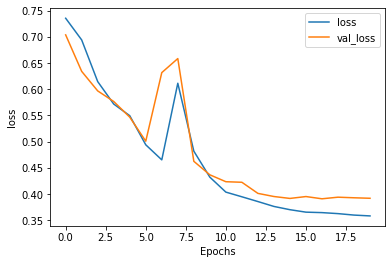

Epoch 1/30
36/36 [==============================] - 9s 53ms/step - loss: 0.6568 - accuracy: 0.6351 - val_loss: 0.5040 - val_accuracy: 0.8541
Epoch 2/30
36/36 [==============================] - 1s 28ms/step - loss: 0.4481 - accuracy: 0.8805 - val_loss: 0.4562 - val_accuracy: 0.8541
Epoch 3/30
36/36 [==============================] - 1s 30ms/step - loss: 0.4141 - accuracy: 0.8938 - val_loss: 0.4302 - val_accuracy: 0.8648
Epoch 4/30
36/36 [==============================] - 1s 28ms/step - loss: 0.3810 - accuracy: 0.8992 - val_loss: 0.4159 - val_accuracy: 0.8577
Epoch 5/30
36/36 [==============================] - 1s 28ms/step - loss: 0.3556 - accuracy: 0.9063 - val_loss: 0.4043 - val_accuracy: 0.8612
Epoch 6/30
36/36 [==============================] - 1s 28ms/step - loss: 0.3335 - accuracy: 0.9090 - val_loss: 0.3985 - val_accuracy: 0.8612
Epoch 7/30
36/36 [==============================] - 1s 27ms/step - loss: 0.3170 - accuracy: 0.9153 - val_loss: 0.3900 - val_accuracy: 0.8612
Epoch 8/30
36

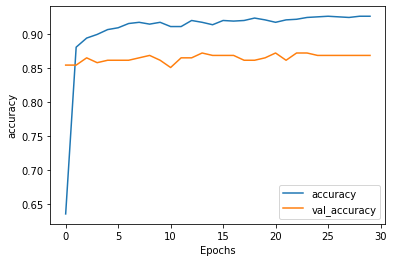

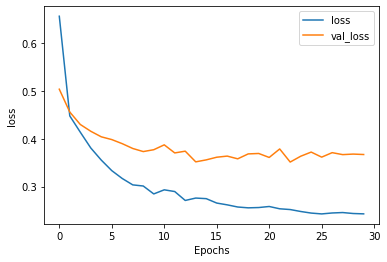

Epoch 1/30
36/36 [==============================] - 19s 133ms/step - loss: 0.7009 - accuracy: 0.5013 - val_loss: 0.6205 - val_accuracy: 0.4947
Epoch 2/30
36/36 [==============================] - 2s 65ms/step - loss: 0.5806 - accuracy: 0.7297 - val_loss: 0.5733 - val_accuracy: 0.7651
Epoch 3/30
36/36 [==============================] - 2s 65ms/step - loss: 0.5073 - accuracy: 0.8332 - val_loss: 0.5018 - val_accuracy: 0.8185
Epoch 4/30
36/36 [==============================] - 3s 98ms/step - loss: 0.4777 - accuracy: 0.8323 - val_loss: 0.4742 - val_accuracy: 0.8256
Epoch 5/30
36/36 [==============================] - 2s 65ms/step - loss: 0.4419 - accuracy: 0.8430 - val_loss: 0.4479 - val_accuracy: 0.8327
Epoch 6/30
36/36 [==============================] - 2s 66ms/step - loss: 0.4237 - accuracy: 0.8787 - val_loss: 0.4354 - val_accuracy: 0.8648
Epoch 7/30
36/36 [==============================] - 2s 66ms/step - loss: 0.4094 - accuracy: 0.8769 - val_loss: 0.4340 - val_accuracy: 0.8327
Epoch 8/30


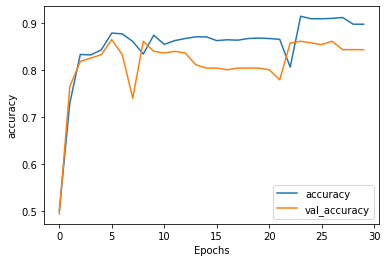

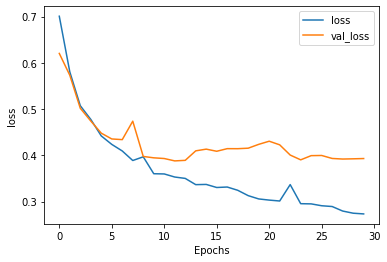

Epoch 1/30
36/36 [==============================] - 27s 175ms/step - loss: 0.6471 - accuracy: 0.6244 - val_loss: 0.5160 - val_accuracy: 0.8363
Epoch 2/30
36/36 [==============================] - 4s 120ms/step - loss: 0.4846 - accuracy: 0.8921 - val_loss: 0.5089 - val_accuracy: 0.8577
Epoch 3/30
36/36 [==============================] - 3s 86ms/step - loss: 0.4637 - accuracy: 0.8733 - val_loss: 0.4505 - val_accuracy: 0.8719
Epoch 4/30
36/36 [==============================] - 3s 84ms/step - loss: 0.4117 - accuracy: 0.8778 - val_loss: 0.4480 - val_accuracy: 0.8327
Epoch 5/30
36/36 [==============================] - 3s 84ms/step - loss: 0.4109 - accuracy: 0.8617 - val_loss: 0.4363 - val_accuracy: 0.8221
Epoch 6/30
36/36 [==============================] - 4s 122ms/step - loss: 0.3963 - accuracy: 0.8582 - val_loss: 0.4128 - val_accuracy: 0.8505
Epoch 7/30
36/36 [==============================] - 3s 78ms/step - loss: 0.3857 - accuracy: 0.8671 - val_loss: 0.4106 - val_accuracy: 0.8541
Epoch 8/3

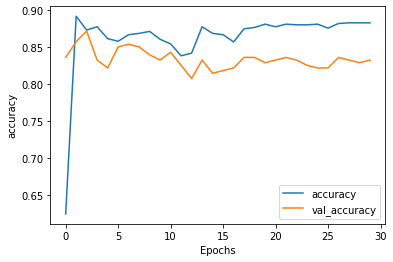

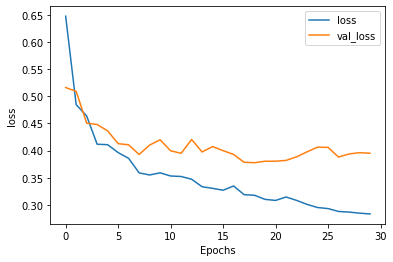

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, GRU, Concatenate, Average
from keras.models import Model
arr_batch = [32]
arr_epochs = [10,20,30]
algo_layers = [1,3,5]
output = {}
idx = 0
for batch in arr_batch:
    for epoch in arr_epochs:
        for layer in algo_layers:


            # Define input layer
            inputs = Input(shape=(X.shape[1],))

            # Define LSTM model
            lstm_model = get_lstm_model(layer)
            lstm_output = lstm_model(inputs)

            # Define GRU model
            gru_model = get_gru_model(layer)
            gru_output = gru_model(inputs)

            # Concatenate outputs from both models
            concat_output = Concatenate()([lstm_output, gru_output])

            # Average the predictions from both models
            average_output = Average()([concat_output])

            # Define the final dense layers
            output_layer = Dense(y.shape[1], activation='softmax')(average_output)

            # Define the ensemble model
            ensemble_model = Model(inputs=inputs, outputs=output_layer)

            # Compile the model
            ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            # Train the model
            history = ensemble_model.fit(X_train, y_train, batch, epoch, validation_data=(X_test, y_test), verbose=1)
            plot_graphs(history, "accuracy")
            plot_graphs(history, "loss")

            #output[idx] = {'batch':batch, 'epoch':epoch, 'num_of_layer':layer, 'acc':ev, 'cm':cm}
            idx = idx+1;

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, GRU, Concatenate, Average
from keras.models import Model

# Define input layer
inputs = Input(shape=(X.shape[1],))

# Define LSTM model
lstm_model = get_lstm_model(num_of_layer=3)
lstm_output = lstm_model(inputs)

# Define GRU model
gru_model = get_gru_model(num_of_layer=5)
gru_output = gru_model(inputs)

# Concatenate outputs from both models
concat_output = Concatenate()([lstm_output, gru_output])

# Average the predictions from both models
average_output = Average()([concat_output])

# Define the final dense layers
output_layer = Dense(y.shape[1], activation='softmax')(average_output)

# Define the ensemble model
ensemble_model = Model(inputs=inputs, outputs=output_layer)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ensemble_model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), verbose=1)


Epoch 1/30
36/36 [==============================] - 20s 142ms/step - loss: 0.8071 - accuracy: 0.4996 - val_loss: 0.7357 - val_accuracy: 0.5018
Epoch 2/30
36/36 [==============================] - 3s 78ms/step - loss: 0.6977 - accuracy: 0.4996 - val_loss: 0.6253 - val_accuracy: 0.5018
Epoch 3/30
36/36 [==============================] - 2s 62ms/step - loss: 0.6197 - accuracy: 0.4996 - val_loss: 0.5910 - val_accuracy: 0.5018
Epoch 4/30
36/36 [==============================] - 2s 66ms/step - loss: 0.5783 - accuracy: 0.4996 - val_loss: 0.5560 - val_accuracy: 0.5018
Epoch 5/30
36/36 [==============================] - 2s 60ms/step - loss: 0.5352 - accuracy: 0.7431 - val_loss: 0.5121 - val_accuracy: 0.8505
Epoch 6/30
36/36 [==============================] - 3s 73ms/step - loss: 0.5020 - accuracy: 0.8510 - val_loss: 0.5261 - val_accuracy: 0.8292
Epoch 7/30
36/36 [==============================] - 3s 87ms/step - loss: 0.4928 - accuracy: 0.8510 - val_loss: 0.4716 - val_accuracy: 0.8541
Epoch 8/30


In [ ]:
output

NameError: ignored

In [ ]:
import json
json_object = json.dumps(output, indent = 4)
with open('model_v0.0.0_gru_dense.json', 'a') as fp:
    fp.write(json_object)

NameError: ignored